In [12]:
%matplotlib inline
from matplotlib import pyplot as plt
import cv2
import numpy as np

In [3]:
sift = cv2.xfeatures2d.SIFT_create()

In [60]:
# spherical warping
img1 = "../dataset/LunchRoom/img01.jpg"
img1 = cv2.imread(img1,cv2.IMREAD_COLOR)
img1 = cv2.resize(img1, (img1.shape[1] // 5, img1.shape[0] // 5))
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)

img9 = "../dataset/LunchRoom/img09.jpg"
img9 = cv2.imread(img9,cv2.IMREAD_COLOR)
img9 = cv2.resize(img9, (img9.shape[1] // 5, img9.shape[0] // 5))
img9 = cv2.cvtColor(img9, cv2.COLOR_BGR2RGB)

In [62]:
R1 = np.eye(3)
R9 = np.array([0.69817162, -0.047327805, 0.71436465,
              0.053232208, 0.99848193, 0.014125548,
             -0.71394897, 0.028165152, 0.69963104]).reshape(3,3)

In [63]:
"""
Fx: 2569.31 Fy: 2566.96
Optical center - Cx: 2755.64 Cy: 1788.42
"""
K = np.array([[2569.31 / 5, 0, 1788.42 / 5], [0, 2566.96 / 5, 2755.64 / 5],[0,0,1]])

In [64]:
img_warp = np.zeros(img.shape)
print(img_warp.shape)

(1094, 729, 3)


In [67]:
'''
Warp an image from cartesian coordinates (x, y) into cylindrical coordinates (theta, h)
Returns: (image, mask)
Mask is [0,255], and has 255s wherever the cylindrical images has a valid value.
Masks are useful for stitching
Usage example:
    im = cv2.imread("myimage.jpg",0) #grayscale
    h,w = im.shape
    f = 700
    K = np.array([[f, 0, w/2], [0, f, h/2], [0, 0, 1]]) # mock calibration matrix
    imcyl = cylindricalWarpImage(im, K)
'''
def sphericalWarpImage(img1, K, R, savefig=False):
    fx, fy = K[0,0], K[1,1]
    cx, cy = K[0,-1], K[1,-1]

    im_h,im_w = img1.shape

    # go inverse from cylindrical coord to the image
    # (this way there are no gaps)
    cyl = np.zeros_like(img1)
    cyl_mask = np.zeros_like(img1)
    cyl_h,cyl_w = cyl.shape

    for x_cyl in np.arange(0,cyl_w):
        for y_cyl in np.arange(0,cyl_h):
            theta = (x_cyl - cx) / fx
#             h     = (y_cyl - y_c) / f
            phi = (y_cyl - cy) / fy

#             X = np.array([math.sin(theta), h, math.cos(theta)])
            X = np.array([math.sin(theta) * math.cos(phi), math.sin(phi), math.cos(theta) * math.cos(phi)])
            X = np.dot(K, np.linalg.inv(R) @ X)
            x_im = X[0] / X[2]
            if x_im < 0 or x_im >= im_w:
                continue

            y_im = X[1] / X[2]
            if y_im < 0 or y_im >= im_h:
                continue

            cyl[int(y_cyl),int(x_cyl)] = img1[int(y_im),int(x_im)]
            cyl_mask[int(y_cyl),int(x_cyl)] = 255


    if savefig:
        plt.imshow(cyl, cmap='gray')
        plt.savefig("cyl.png",bbox_inches='tight')

    return (cyl,cyl_mask)

In [68]:
gray1 = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
gray9 = cv2.cvtColor(img9, cv2.COLOR_RGB2GRAY)

In [73]:
import math
warp1 = sphericalWarpImage(gray1, K, R1, savefig=False)
warp9 = sphericalWarpImage(gray9, K, R9, savefig=False)

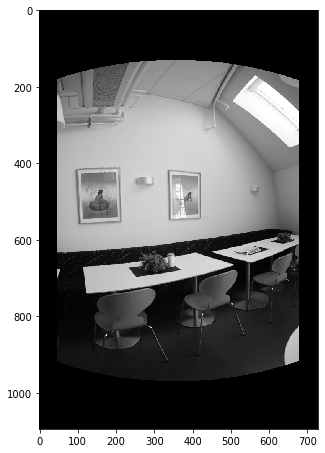

In [75]:
plt.figure(figsize=(5,10))
plt.imshow(warp1[0], cmap='gray')
plt.show()

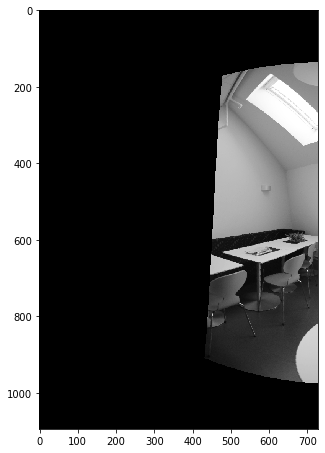

In [76]:
plt.figure(figsize=(5,10))
plt.imshow(warp9[0], cmap='gray')
plt.show()

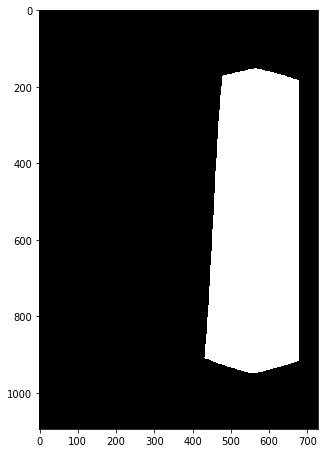

In [116]:
plt.figure(figsize=(5,10))
plt.imshow(np.logical_and(warp1[1], warp9[1]), cmap='gray')

In [120]:
mask1 = warp1[1]
mask9 = warp9[1]
section = np.logical_and(mask1, mask9).astype(np.float)
mask1 = mask1.astype(np.float)
mask9 = mask9.astype(np.float)

In [125]:
section.shape

(1094, 729)

In [123]:
blend = (warp1 * mask1 - warp1 * section) + (warp9 * mask9 - warp9 * section)
blend += 0.5 * (warp1 * section + warp9 * section)

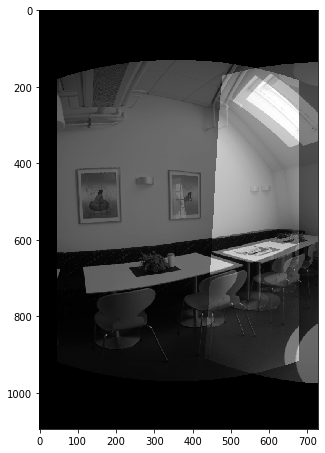

In [129]:
plt.figure(figsize=(5,10))
plt.imshow(blend[0], cmap='gray')
plt.show()

In [172]:
def Laplacian_blending(img1,img2,mask,levels=2):
    G1 = img1.copy()
    G2 = img2.copy()
    GM = mask.copy()
    gp1 = [G1]
    gp2 = [G2]
    gpM = [GM]
    for i in range(levels):
        G1 = cv2.pyrDown(G1)
        G2 = cv2.pyrDown(G2)
        GM = cv2.pyrDown(GM)
        gp1.append(np.float32(G1))
        gp2.append(np.float32(G2))
        gpM.append(np.float32(GM))
    
    for i, pryImg in enumerate(gp1):
        print(f"pyr level {i}: shape: {pryImg.shape}")
    # generate Laplacian Pyramids for A,B and masks
    lp1  = [gp1[levels-1]] # the bottom of the Lap-pyr holds the last (smallest) Gauss level
    lp2  = [gp2[levels-1]]
    gpMr = [gpM[levels-1]]
    for i in reversed(range(1,levels+1)):
    # Laplacian: subtarct upscaled version of lower level from current level
    # to get the high frequencies
        print(i)
        print("pyrUp", cv2.pyrUp(gp1[i]).shape)
        print("origin", gp1[i-1].shape)
        L1 = np.subtract(gp1[i-1], cv2.resize(cv2.pyrUp(gp1[i]), (gp1[i-1].shape[1], gp1[i-1].shape[0]), interpolation=cv2.INTER_LINEAR))
        L2 = np.subtract(gp2[i-1], cv2.resize(cv2.pyrUp(gp2[i]), (gp2[i-1].shape[1], gp2[i-1].shape[0]), interpolation=cv2.INTER_LINEAR))
        lp1.append(L1)
        lp2.append(L2)
        gpMr.append(gpM[i-1]) # also reverse the masks

    # Now blend images according to mask in each level
    LS = []
    for l1,l2,gm in zip(lp1,lp2,gpMr):
        ls = l1 * gm + l2 * (1.0 - gm)
        LS.append(ls)

    # now reconstruct
    ls_ = LS[0]
    for i in range(1,levels):
        ls_ = cv2.pyrUp(ls_)
    ls_ = cv2.add(ls_, LS[i])

    return ls_

In [173]:
warp[1].shape

(1094, 729)

In [208]:
import cv2
import numpy as np
def Laplacian_Pyramid_Blending_with_mask(A, B, m, num_levels = 6):
    # assume mask is float32 [0,1]

    # generate Gaussian pyramid for A,B and mask
    GA = A.copy()
    GB = B.copy()
    GM = m.copy()
    gpA = [GA]
    gpB = [GB]
    gpM = [GM]
    for i in range(num_levels):
        GA = cv2.pyrDown(GA)
        GB = cv2.pyrDown(GB)
        GM = cv2.pyrDown(GM)
        gpA.append(np.float32(GA))
        gpB.append(np.float32(GB))
        gpM.append(np.float32(GM))

    # generate Laplacian Pyramids for A,B and masks
    lpA  = [gpA[num_levels-1]] # the bottom of the Lap-pyr holds the last (smallest) Gauss level
    lpB  = [gpB[num_levels-1]]
    gpMr = [gpM[num_levels-1]]
    for i in range(num_levels-1,0,-1):
        # Laplacian: subtarct upscaled version of lower level from current level
        # to get the high frequencies
        LA = np.subtract(gpA[i-1], cv2.resize(cv2.pyrUp(gpA[i]), (gpA[i-1].shape[1], gpA[i-1].shape[0]), cv2.INTER_LINEAR))
        LB = np.subtract(gpB[i-1], cv2.resize(cv2.pyrUp(gpB[i]), (gpB[i-1].shape[1], gpB[i-1].shape[0]), cv2.INTER_LINEAR))
        lpA.append(LA)
        lpB.append(LB)
        gpMr.append(gpM[i-1]) # also reverse the masks

    # Now blend images according to mask in each level
    LS = []
    for la,lb,gm in zip(lpA,lpB,gpMr):
        ls = la * gm + lb * (1.0 - gm)
        LS.append(ls)

    # now reconstruct
    ls_ = LS[0]
    for i in range(1,num_levels):
        ls_ = cv2.resize(cv2.pyrUp(ls_), (LS[i].shape[1], LS[i].shape[0]), cv2.INTER_LINEAR)
        ls_ = cv2.add(ls_, LS[i], dtype = cv2.CV_32F)

    return ls_

255

In [231]:
A = warp1[0] / 255
B = warp9[0] / 255
m = cv2.bitwise_and(warp1[1], warp9[1])
lpb = Laplacian_Pyramid_Blending_with_mask(A, B, m, 4)

In [234]:
lpb /= lpb.max()

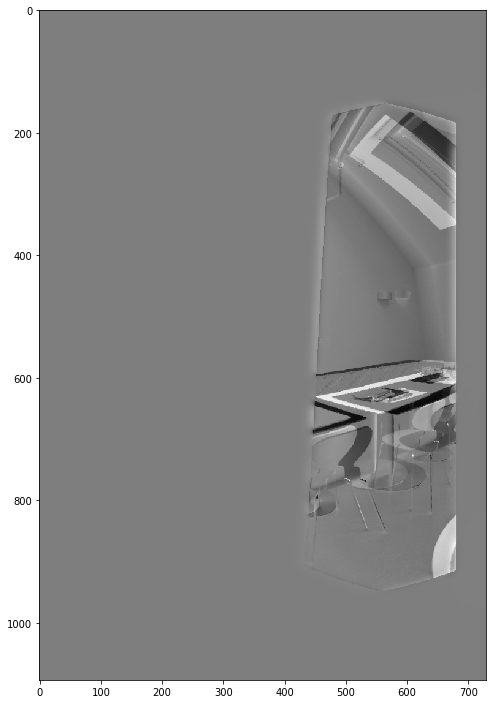

In [238]:
plt.figure(figsize=(8,16))
plt.imshow(lpb, cmap='gray')